In [1]:
import os
import time
import yaml
import math
import pandas as pd
import numpy as np

In [2]:
from data.excel2pd import data_load
from data.preprocessing import data_preprocessing
from data.train_test_split import data2Window, X_Y2train_test, X_Y_from_data
from data.CustomDataset import CustomDataset

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더
from model.model import LSTM

In [4]:
# torch version, gpu 사용 여부, 이름 체크
print("torch version>>", torch.__version__)
print("GPU 사용 유무>>", torch.cuda.is_available())
if torch.cuda.is_available() :
    print("GPU 이름>> ", torch.cuda.get_device_name(0))
    device = "cuda:0" 
else :
    device = "cpu"
print(device)

torch version>> 1.13.1
GPU 사용 유무>> True
GPU 이름>>  NVIDIA GeForce RTX 2080
cuda:0


In [5]:
f = open("Settings.yaml", 'r')
setup = yaml.load(f, Loader=yaml.FullLoader)

data = data_load(11)
scaler, data = data_preprocessing(data, setup['data_options'])

X, Y = X_Y_from_data(data)

if setup['data_options']['CGM'] == 3:
    input_size = 1
else:
    input_size = 3

X_train, Y_train, X_test, Y_test = X_Y2train_test(X=X, Y=Y,
                                                  output_window=setup['output_window'],
                                                  input_size=input_size,
                                                  stride=setup['stride'])

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(51166, 6, 1) (51166, 6)
(309, 6) (309, 6)


In [6]:
dataset = CustomDataset(X_train, Y_train)
dataloader = DataLoader(dataset, batch_size = setup['batch'], shuffle=False)

In [7]:
model = LSTM(device = device,
             input_size=input_size, 
             hidden_size=setup['LSTM'],
             num_layer=setup['num_layers'], 
             dropout=setup['dropout']
             ).to(device)

c:\ProgramData\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [8]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 67,201 trainable parameters


In [11]:
model.train()

LSTM(
  (LSTM0): LSTM(1, 128, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
from model.train import train

model, optimizer = train(device = device, model = model, 
                         dataloader = dataloader, 
                         learning_rate = setup['learning_rate'], 
                         epochs = setup['epoch'],
                         output_window = setup['output_window'])

  0%|          | 0/500 [00:00<?, ?it/s]


AttributeError: 'LSTM' object has no attribute 'device'

In [ ]:
#model save
import os
from datetime import datetime
#from model.train import save_model

now = datetime.now()
save_path = "./result/"+now.strftime('%Y_%m_%d_%H_%M')
try:
    if not os.path.exists(save_path) : 
        os.mkdir(save_path)
except:
    print("Error : Failed to create the directory.")

#save_model(save_path, model, optimizer)

In [ ]:
from model.predict import predict

prediction = predict(model, X_test, setup['output_window'], scaler, setup['data_options']['CGM'], device)

3


[datetime.datetime(2024, 4, 11, 18, 31, 42, 106114), 30.48574755029771, 20.380917741514207, 34.97138524188669, 25.43829314205372]


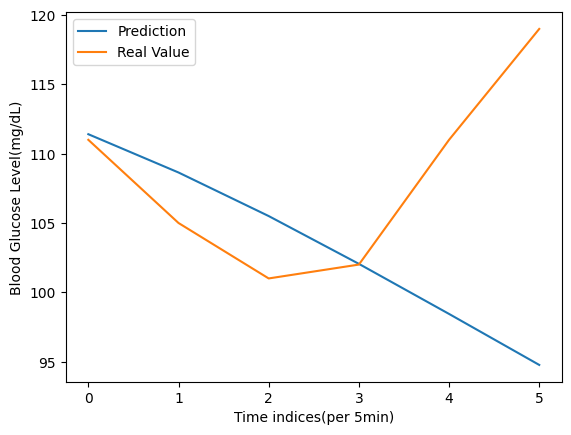

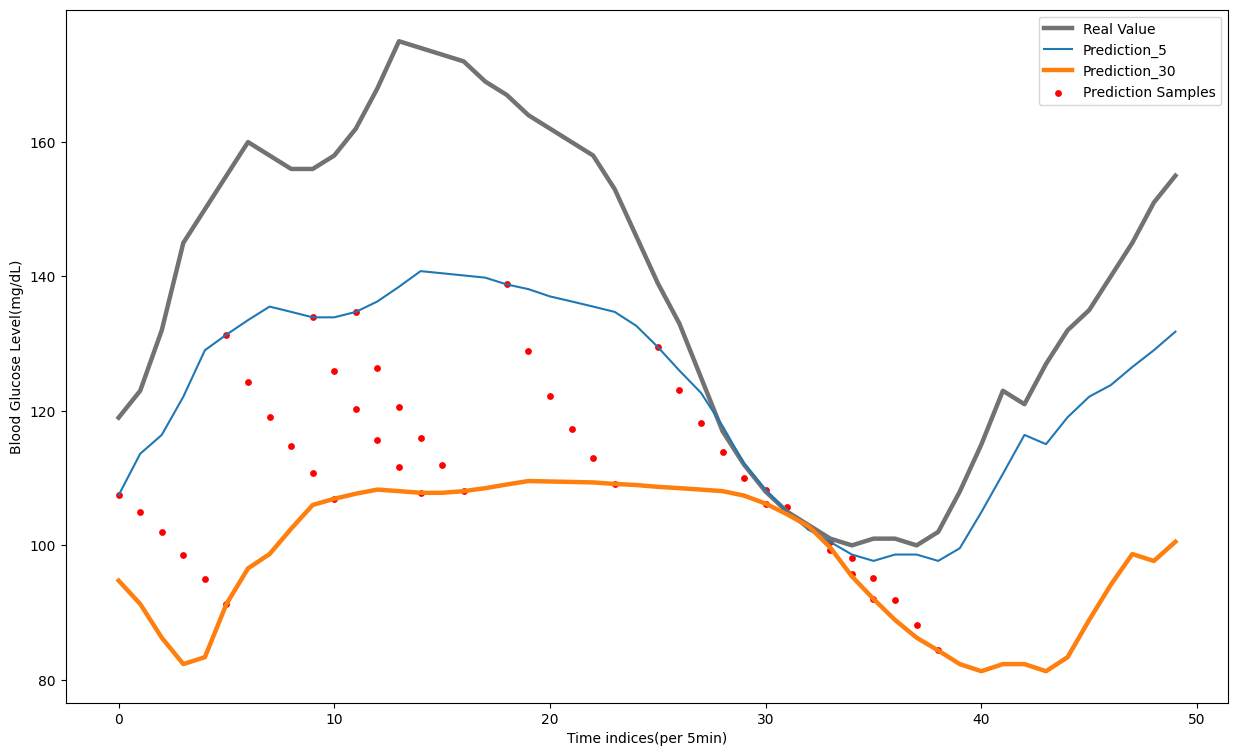

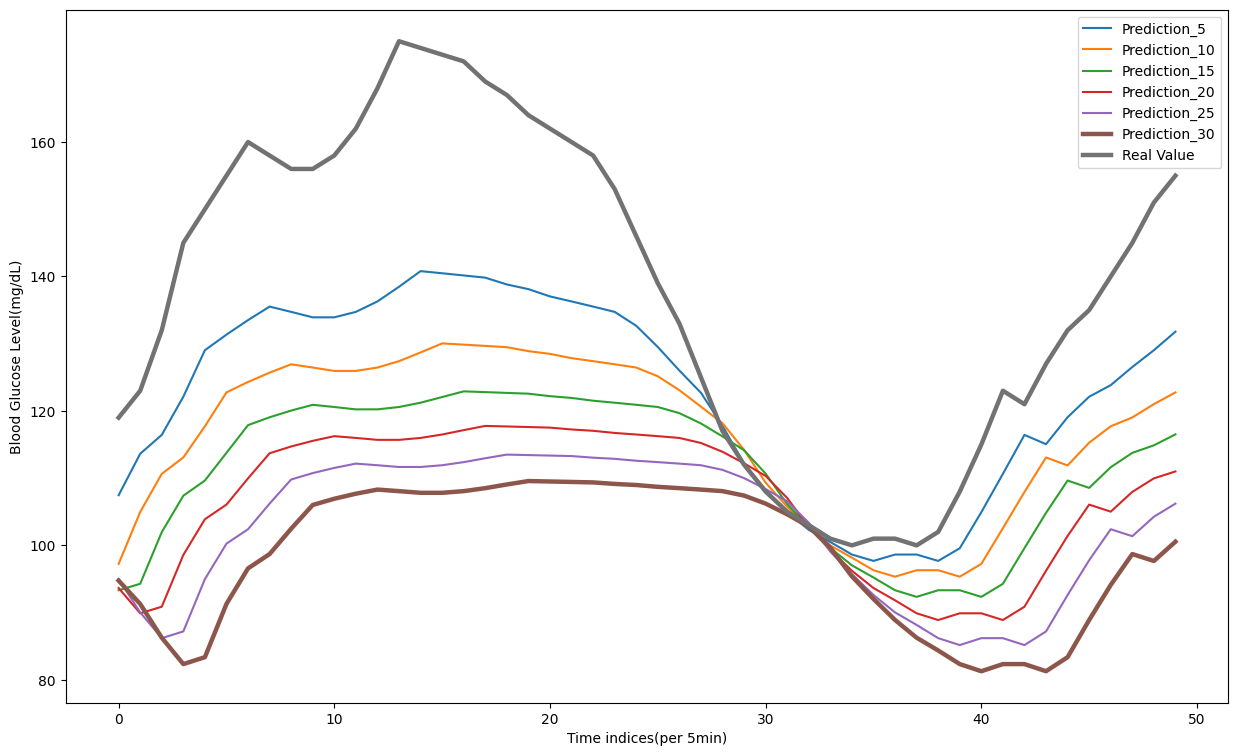

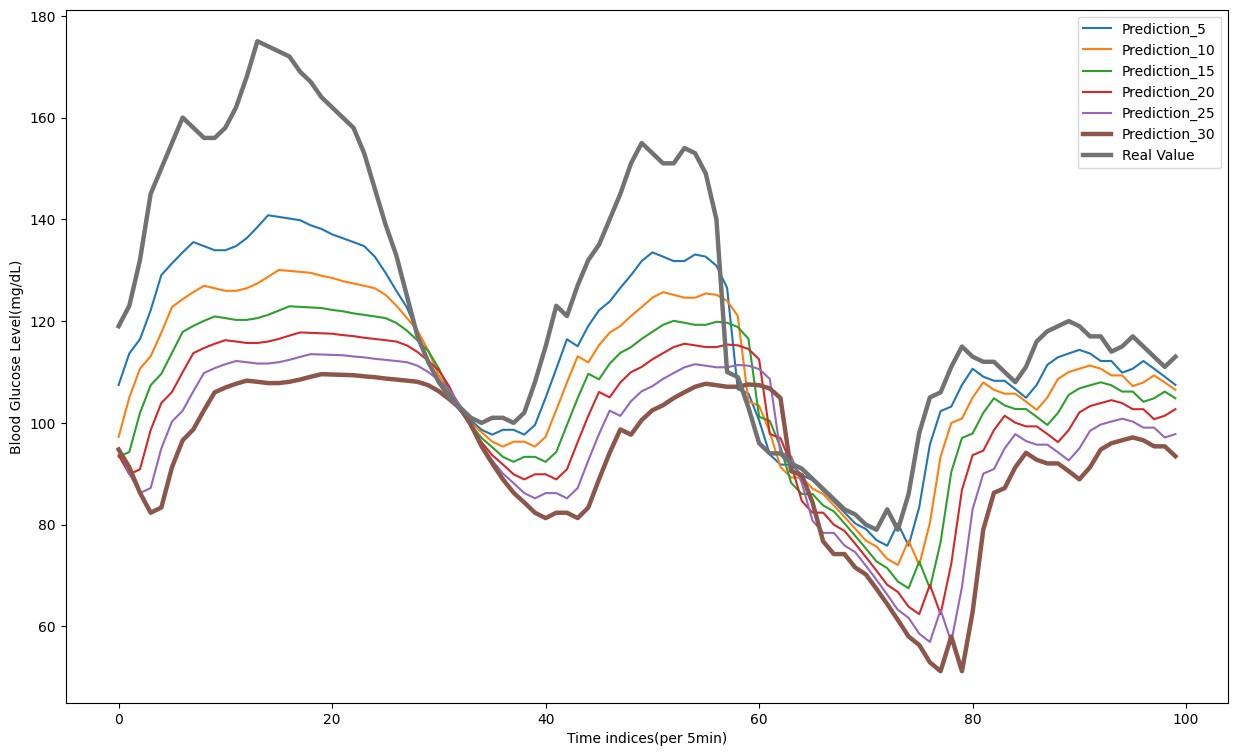

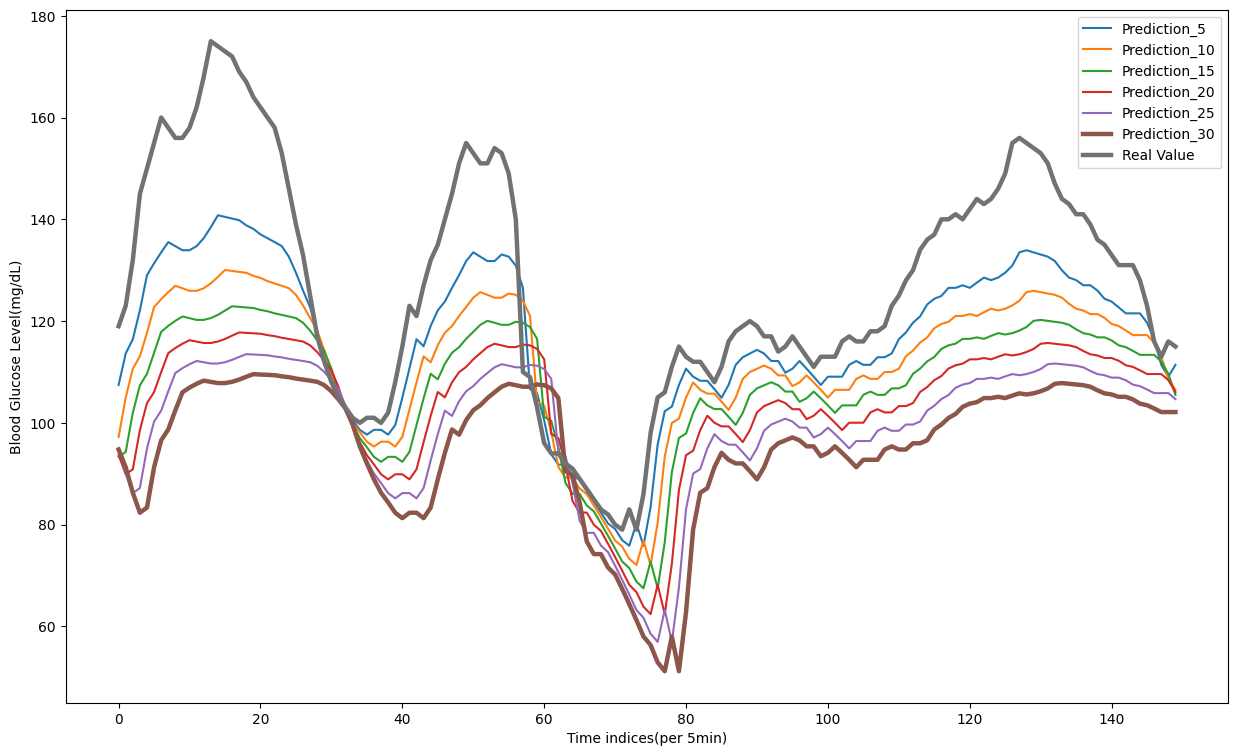

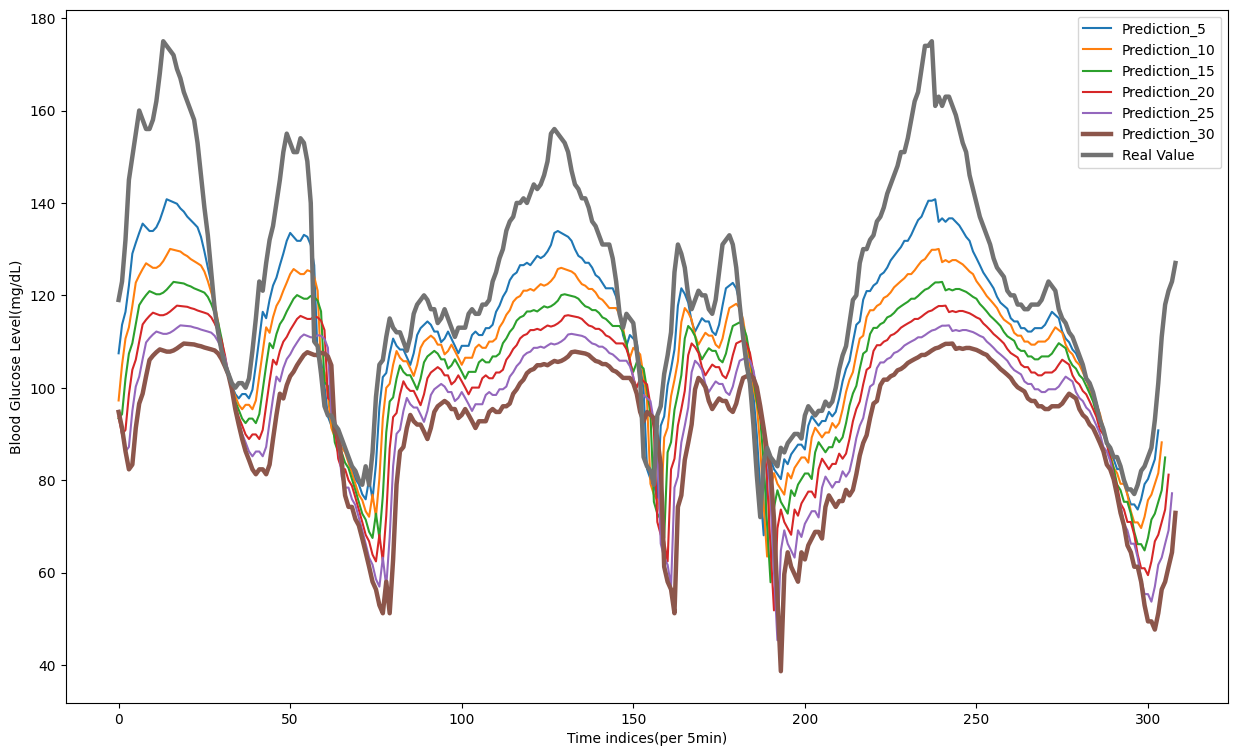

In [ ]:
from model.result import result_jpg, save_yaml_and_error, save_numeric_result

result_jpg(prediction, Y_test, save_path)
save_yaml_and_error("./", save_path, now)
save_numeric_result(prediction, Y_test, now)